In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import os
import seaborn as sns
import sys
import numpy as np
import math

#!{sys.executable} -m pip install venn
from PIL import Image
import venn
import matplotlib as mpl
from matplotlib import cm
!{sys.executable} -m pip install colorspacious
from colorspacious import cspace_converter
from collections import OrderedDict
import random
cmaps = OrderedDict()

import venn

### Define patients missing samples types

In [52]:
no_w2 = ['1769']
no_restim =['1813']
no_s6m = ['1775', '1782']
no_6m = ['1775', '1790']
no_d28 = ['1802']

empty_df = pd.DataFrame(columns=['count', 'freq', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart',
       'DEnd', 'JStart'])

### Define pools for demultiplexing

In [3]:
pool1 = {'1752': 'YLQorVRF', '1771': 'KCY', '1775': 'RLQ' , '1800': 'FCN'}

pool2 = {'1752': 'YLQorIED', '1771': 'KCY', '1775': 'VRF', '1800': 'FCN'}

pool3 = {'1753': 'IED', '1775': 'YLQ', '1776':'LTD', '1787':'KCY', '1802': 'QYI'}

pool4 = {'1753': 'IED', '1775': 'YLQ', '1776': 'LTD', '1787': 'KCY', '1802': 'QYI'}

pool6 = {'1753': 'QYI', '1782': 'YLQ', '1790': 'KCYorLTD'}

pool5 = pool6

pool7 = {'1753': 'LTD', '1780': 'QYI', '1792': 'KCY', '1810': 'YLQ'}

pool8 = {'1753': 'LTD', '1792': 'IEDorKCY', '1810': 'YLQ'}

pool9 = {'1771': 'GLR', '1792':'QQL', '1810': 'KCY', '1813': 'YLQ'}

pool10 = {'1771':'GLR', '1792':'FCN', '1810':'KCY', '1813': 'YLQ'}

pool11 = {'1752':'RLQ', '1771':'LPQ', '1800':'LTD', '1813':'KCY'}

pool12 = {'1752':'RLQ', '1771':'LPQ', '1800':'LTD', '1813':'KCY'}

pools = {'1':pool1, '2':pool2, '3':pool3, '4':pool4, '5':pool5, '6':pool6, '7':pool7, '8':pool8, 
         '9':pool9, '10':pool10, '11':pool11, '12':pool12}
patient_dict_default = {'1752': {'YLQ': ['YLQ 1'], 'RLQ': ['RLQ 11', 'RLQ 12'], 'VRFornot': ['VRFornot 1'], 'IEDornot': ['IEDornot 2']},
               '1753': {'IED': ['IED 3', 'IED 4'], 'QYI': ['QYI 5', 'QYI 6'], 'LTD': ['LTD 7', 'LTD 8']},
               '1771': {'GLR': ['GLR 9', 'GLR 10'], 'LPQ': ['LPQ 11', 'LPQ 12'], 'KCY':['KCY 1', 'KCY 2']},
               '1775': {'RLQ': ['RLQ 1'], 'VRF': ['VRF 2'], 'YLQ': ['YLQ 3', 'YLQ 4']},
               '1776': {'LTD': ['LTD 3', 'LTD 4']},
               '1780': {'QYI': ['QYI 7']},
               '1782': {'YLQ': ['YLQ 5', 'YLQ 6']},
              '1787': {'KCY': ['KCY 3', 'KCY 4']},
               '1790': {'KCYorLTD': ['KCYorLTD 5', 'KCYorLTD 6']},
               '1792': {'IEDornot':['IEDornot 8'], 'QQL':['QQL 9'], 'KCY':['KCY 7'], 'FCN':['FCN 10']},
               '1800': {'LTD': ['LTD 11', 'LTD 12'], 'FCN': ['FCN 1', 'FCN 2']},
               '1802': {'QYI': ['QYI 3', 'QYI 4']},
               '1810': {'YLQ': ['YLQ 7', 'YLQ 8'], 'KCY': ['KCY 9', 'KCY 10']},
               '1813': {'YLQ': ['YLQ 9', 'YLQ 10'], 'KCY': ['KCY 11', 'KCY 12']}}
resolve_specificity = [{'YLQ': {'1':pool1['1752'], '2':pool2['1752']}, 'VRFornot':{'1':pool1['1752']}, 
                       'IEDornot': {'2':pool2['1752']}},
                        {'KCY':{'7':pool7['1792'], '8':pool8['1792']}, 'IEDornot':{'8':pool8['1792']}}]

### Define functions

In [4]:
def define_specificities(df, freq_type, pools_list, pool_number, patient_list, th, path_to_res, overseq=100, save=False, fill_na=0):
    if fill_na == 0:
        df = df.fillna(0)
    elif fill_na == 'min':
        df = df.fillna(99999999)
        li_min_freq = []
        for pat in list(range(len(patient_list))):
            li_min_freq.append(min(df['freq_'+patient_list[pat]]))
        min_freq = min(li_min_freq)

        df = df.replace(to_replace=99999999, value=min_freq) #fill NaN with small number
    else:
        df = df.fillna(fill_na)
    print(len(df))
    all_unique_specificities = pd.DataFrame()
    number_unique_specific = []
    for pat_number in list(range(len(patient_list))):
        except_this_patient = patient_list[:pat_number]+patient_list[pat_number+1:]
        if len(patient_list) == 3:
            this_specificity = df[(df['freq_'+patient_list[pat_number]]>overseq*df['freq_'+except_this_patient[0]])&(df['freq_'+patient_list[pat_number]]>overseq*df['freq_'+except_this_patient[1]])]
        elif len(patient_list) == 4:
            this_specificity = df[(df['freq_'+patient_list[pat_number]]>overseq*df['freq_'+except_this_patient[0]])&(df['freq_'+patient_list[pat_number]]>overseq*df['freq_'+except_this_patient[1]])&(df['freq_'+patient_list[pat_number]]>overseq*df['freq_'+except_this_patient[2]])]
        elif len(patient_list) == 5:
            this_specificity = df[(df['freq_'+patient_list[pat_number]]>overseq*df['freq_'+except_this_patient[0]])&(df['freq_'+patient_list[pat_number]]>overseq*df['freq_'+except_this_patient[1]])&(df['freq_'+patient_list[pat_number]]>overseq*df['freq_'+except_this_patient[2]])&(df['freq_'+patient_list[pat_number]]>overseq*df['freq_'+except_this_patient[3]])]
        print(patient_list[pat_number], len(this_specificity))
        this_specificity = this_specificity[['cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'VEnd', 'DStart', 'DEnd', 'JStart', 'freq_'+patient_list[pat_number], 'count_'+patient_list[pat_number], 'freq_'+pools[pool_num-1][patient_list[pat_number]], 'count_'+pools[pool_num-1][patient_list[pat_number]]]]
        number_unique_specific.append(len(this_specificity))
        if save == True:
            path_to_this_specificity = path_to_res + patient_list[pat_number] +'_' + pools[pool_num-1][patient_list[pat_number]] + '.txt'
            this_specificity.to_csv(path_to_this_specificity, sep='\t', index = False)
        #Rename columns for plots
        this_specificity['type'] = th + '_' + patient_list[pat_number] +'_' + pools[pool_num-1][patient_list[pat_number]]
        if freq_type == 'patient':
            this_specificity['freq'] = this_specificity['freq_'+patient_list[pat_number]] 
        elif freq_type == 'pool':
            this_specificity['freq'] = this_specificity['freq_'+pools[pool_num-1][patient_list[pat_number]]] 
        this_specificity = this_specificity[['freq', 'type', 'cdr3nt', 'cdr3aa', 'v', 'd', 'j']]
        #Merge all specificities for plot
        all_unique_specificities = all_unique_specificities.append(this_specificity)
    return all_unique_specificities, number_unique_specific

### Get intersection/all_clones/top 75% of totals

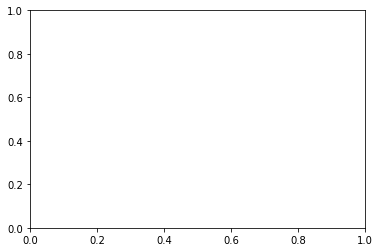

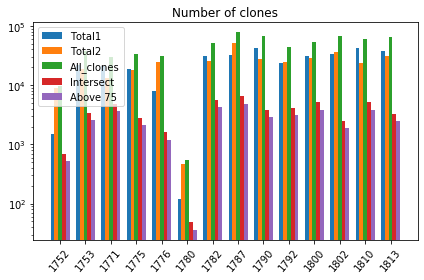

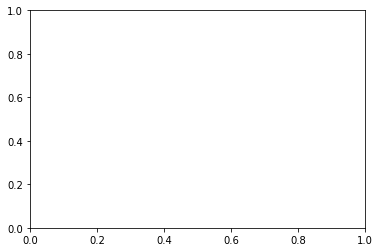

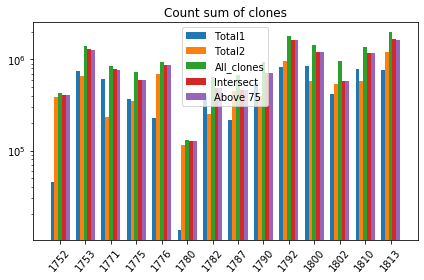

In [5]:
subject_list = ['1752', '1753', '1771', '1775', '1776', '1780', '1782', '1787', '1790',
               '1792', '1800', '1802', '1810', '1813']
summary_clones_total = pd.DataFrame()
#subject_list = subject_list[:2]
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig4/'


path_all_clones = path_all+'totals/all_clones/' 
path_only_intersect = path_all+'totals/only_intersect/' 
path_abv_75 = path_all+'totals/to_use_above_75/' 
os.makedirs(path_all_clones, exist_ok = True)
os.makedirs(path_only_intersect, exist_ok = True)
os.makedirs(path_abv_75, exist_ok = True)

totals1_nums = []
totals2_nums = []
all_clones_num = []
intersect_num = []

totals1_freq = []
totals2_freq = []
all_clones_freq = []
intersect_freq = []

above_thr_75_nums = []
above_thr_75_freq = []
    
subject_list_from_all_clones = ['1752', '1780']

for person in subject_list:
    path_to_1 = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/GE41/vdj_files/nc.vdj.Tf-' + person + '-1.clonotypes.TRB.txt'
    path_to_2 = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/GE41/vdj_files/nc.vdj.Tf-' + person + '-2.clonotypes.TRB.txt'
    path_all_clones_person = path_all_clones + person + '.txt'
    path_only_intersect_person = path_only_intersect + person + '.txt'
    path_above_thr_75 = path_abv_75 + person + '.txt'
    tot1 = pd.read_csv(path_to_1, delimiter = '\t')
    tot1 = tot1.loc[:, ['count','freq','cdr3nt','cdr3aa','v','d','j']]
    tot2 = pd.read_csv(path_to_2, delimiter = '\t')
    tot2 = tot2.loc[:, ['count','freq','cdr3nt','cdr3aa','v','d','j']]
    
    all_clones = tot1.merge(tot2, how='outer', on=['cdr3nt','cdr3aa','v','d','j']).fillna(0)
    all_clones['count'] = all_clones['count_x'] + all_clones['count_y'] 
    all_clones['freq'] = all_clones['count']/all_clones['count'].sum()
    all_clones = all_clones.drop(columns=['count_x', 'count_y', 'freq_x', 'freq_y']).sort_values(by=['count'], ascending=False).reset_index(drop=True)
    all_clones.to_csv(path_all_clones_person, sep='\t', index=False)
    
    only_intersect = tot1.merge(tot2, how='inner', on=['cdr3nt','cdr3aa','v','d','j'])
    only_intersect['count'] = only_intersect['count_x'] + only_intersect['count_y'] 
    only_intersect['freq'] = only_intersect['count']/only_intersect['count'].sum()
    only_intersect = only_intersect.drop(columns=['count_x', 'count_y', 'freq_x', 'freq_y']).sort_values(by=['count'], ascending=False).reset_index(drop=True)
    only_intersect.to_csv(path_only_intersect_person, sep='\t', index=False)
    
    totals1_nums += [len(tot1)]
    totals2_nums += [len(tot2)]
    all_clones_num += [len(all_clones)]
    intersect_num += [len(only_intersect)]
    
    totals1_freq += [tot1['count'].sum()]
    totals2_freq += [tot2['count'].sum()]
    all_clones_freq += [all_clones['count'].sum()]
    intersect_freq += [only_intersect['count'].sum()]
    
    if person in subject_list_from_all_clones:
        above_thr_75 = all_clones.head(int(len(only_intersect)*0.75))
    else:
        above_thr_75 = only_intersect.head(int(len(only_intersect)*0.75))
    
    above_thr_75.to_csv(path_above_thr_75, sep='\t', index=False)
    
    above_thr_75_nums += [len(above_thr_75)]
    above_thr_75_freq += [above_thr_75['count'].sum()]
    
    plots_list_num = {'patient': person, 'num total 1':len(tot1), 'num total 2':len(tot2),  'num all clones summarized':len(all_clones), 
                  'num only intersected':len(only_intersect), 'num above 75':len(above_thr_75),
                      'count_sum total 1':tot1['count'].sum(),
                           'count_sum total 2':tot2['count'].sum(),  'count_sum all clones summarized':all_clones['count'].sum(), 
                  'count_sum only intersected':only_intersect['count'].sum(),
                     'count_sum above 75': above_thr_75['count'].sum()}
    summary_clones_total = summary_clones_total.append(plots_list_num, ignore_index=True)

nums_list = [totals1_nums,totals2_nums,all_clones_num,intersect_num,above_thr_75_nums]
count_sum_list = [totals1_freq,totals2_freq,all_clones_freq,intersect_freq,above_thr_75_freq]

summary_clones_total_path = path_all+'totals/clones_number_and_freq.txt'
summary_clones_total.to_csv(summary_clones_total_path, sep='\t', index=False)   

#Plot numbers and freqs

graph_types = 'num', 'count_sum'
for graph_type in graph_types:
    if graph_type == 'num':
        ys = nums_list
        tit ='Number of clones'
        png_path = path_all+'totals/clones_number.png'
    elif graph_type == 'count_sum':
        ys = count_sum_list
        tit ='Count sum of clones'
        png_path = path_all+'totals/clones_count_sum.png'
    fig, ax = plt.subplots()
    x = np.arange(len(subject_list))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width*2, ys[0], width, label='Total1')
    rects2 = ax.bar(x - width, ys[1], width, label='Total2')
    rects3 = ax.bar(x , ys[2], width, label='All_clones')
    rects4 = ax.bar(x + width, ys[3], width, label='Intersect')
    rects5 = ax.bar(x + width*2, ys[4], width, label='Above 75')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    #ax.set_ylabel('Number of clones')
    ax.set_title(tit)
    ax.set_xticks(x)
    ax.set_yscale('log')
    ax.set_xticklabels(subject_list, rotation=50)
    ax.legend()

    fig.tight_layout()

    plt.savefig(png_path)
    plt.show()

## Get top 25% of pools

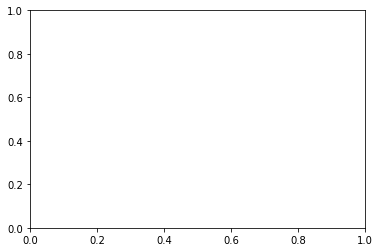

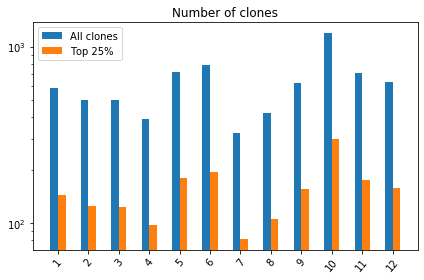

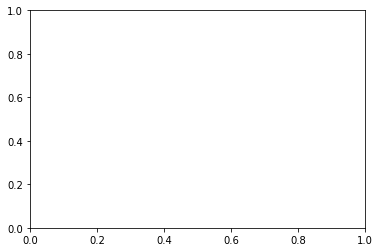

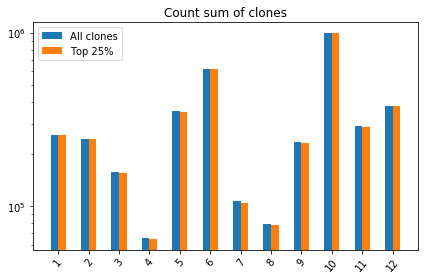

In [6]:
#Number of reads per clone in pools 
#CUT threshold
subject_list = list(range(1,13))
#subject_list = subject_list[:2]
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig4/'
path_to_above_thr_25 = path_all+'pools/above_thr_25/' 
os.makedirs(path_to_above_thr_25, exist_ok = True)

summary_pools = pd.DataFrame()

pool_num = []
abv_25_num = []

pool_freq = []
abv_25_freq = []

for person in subject_list:
    path_to_pool = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/GE41/vdj_files/nc.vdj.Pool-'+str(person)+'.clonotypes.TRB.txt'
    path_to_above_thr_25_person = path_to_above_thr_25 + str(person) +'.txt'
    
    pool = pd.read_csv(path_to_pool, delimiter = '\t')
    above_thr_25 = pool.head(int(len(pool)*0.25)).loc[:,['count', 'freq', 'cdr3nt','cdr3aa','v','d','j']]
    above_thr_25.to_csv(path_to_above_thr_25_person, sep='\t', index=False)
    
    pool_num += [len(pool)]
    abv_25_num += [len(above_thr_25)]
    
    pool_freq += [pool['count'].sum()]
    abv_25_freq += [above_thr_25['count'].sum()]
    
    pool_row = {'pool': str(person), 'num clones all': len(pool), 'num top25%': len(above_thr_25),
               'count_sum clones all': pool['count'].sum(), 'count_sum top25%': above_thr_25['count'].sum()}
    
    summary_pools = summary_pools.append(pool_row, ignore_index=True)

summary_pools_path = path_all+'pools/summary.txt'
summary_pools.to_csv(summary_pools_path, index=False, sep='\t')

#Plot
nums_list = [pool_num,abv_25_num]
count_sum_list = [pool_freq,abv_25_freq]


graph_types = 'num', 'count_sum'
for graph_type in graph_types:
    if graph_type == 'num':
        ys = nums_list
        tit ='Number of clones'
        png_path = path_all+'pools/clones_number.png'
    elif graph_type == 'count_sum':
        ys = count_sum_list
        tit ='Count sum of clones'
        png_path = path_all+'pools/clones_count_sum.png'
    fig, ax = plt.subplots()
    x = np.arange(len(subject_list))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, ys[0], width, label='All clones')
    rects2 = ax.bar(x + width/2, ys[1], width, label='Top 25%')
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    #ax.set_ylabel('Number of clones')
    ax.set_title(tit)
    ax.set_xticks(x)
    ax.set_yscale('log')
    ax.set_xticklabels(subject_list, rotation=50)
    ax.legend()

    fig.tight_layout()

    plt.savefig(png_path)

## Define specificity (new?)

In [7]:
def define_specificity(df, patient, pool_num):
    
    this_pat_freq = 'freq_'+patient
    freq_cols = [col for col in list(df.columns) if ('freq_' in col)&('freq_'+pool_num != col)&(this_pat_freq != col)]
    
    if len(freq_cols) == 2:
        this_epi_patient_pair = df[(df[this_pat_freq]>10*df[freq_cols[0]])&(df[this_pat_freq]>10*df[freq_cols[1]])]
    elif len(freq_cols) == 3:
        this_epi_patient_pair = df[(df[this_pat_freq]>10*df[freq_cols[0]])&(df[this_pat_freq]>10*df[freq_cols[1]])&(df[this_pat_freq]>10*df[freq_cols[2]])]
    elif len(freq_cols) == 4:
        this_epi_patient_pair = df[(df[this_pat_freq]>10*df[freq_cols[0]])&(df[this_pat_freq]>10*df[freq_cols[1]])&(df[this_pat_freq]>10*df[freq_cols[2]])&(df[this_pat_freq]>10*df[freq_cols[3]])]
    elif len(freq_cols) == 5:
        this_epi_patient_pair = df[(df[this_pat_freq]>10*df[freq_cols[0]])&(df[this_pat_freq]>10*df[freq_cols[1]])&(df[this_pat_freq]>10*df[freq_cols[2]])&(df[this_pat_freq]>10*df[freq_cols[3]])&(df[this_pat_freq]>10*df[freq_cols[4]])]
    return(this_epi_patient_pair)

In [8]:
#pools_test = pools[:1]
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig4/'

all_patient_totals_path = path_all+'totals/to_use_above_75/' 
all_pools_path = path_all+'pools/above_thr_25/' 
all_epitope_path = path_all+'epitopes/' 
os.makedirs(all_epitope_path, exist_ok = True)
number_epitopes = {}

summary_epi_patients = open(path_all+"epitopes/all_epits_summary.txt","w+")


for pool_num in list(pools.keys()):
    pool_epitope_path = path_all+'epitopes/pool'+pool_num+'/' 
    os.makedirs(pool_epitope_path, exist_ok = True)

    all_patient_in_pool = pd.DataFrame(columns=['cdr3nt','cdr3aa','v','d','j'])
    pool_path = all_pools_path + pool_num + '.txt'
    pool_file = pd.read_csv(pool_path, delimiter='\t')
    pool_file = pool_file.rename(columns={'freq': 'freq_'+pool_num, 'count': 'count_'+pool_num})
    for patient in list(pools[pool_num].keys()):
        patient_total_path = all_patient_totals_path + patient + '.txt'
        patient_total = pd.read_csv(patient_total_path, delimiter='\t')
        patient_total = patient_total.rename(columns={'freq': 'freq_'+patient, 'count': 'count_'+patient})
        patient_total['num_patient_'+patient] = 1
        all_patient_in_pool = all_patient_in_pool.merge(patient_total, how='outer', on=['cdr3nt','cdr3aa','v','d','j'])
        #prefix_tot = '_'+patient
        #prefix_pool = '_pool'+pool_num
        #patient_epitope_pair = pool_file.merge(patient_total, how='inner', on=['cdr3nt','cdr3aa','v','d','j'], suffixes=[prefix_tot, prefix_pool]).reset_index(drop=True)
    
    pool_epitope = pool_file.merge(all_patient_in_pool, how='left', on=['cdr3nt','cdr3aa','v','d','j']).fillna(0)
    columns_num_patients = [col for col in list(pool_epitope.columns) if 'num_patient_' in col]
    pool_epitope['num_patients'] = pool_epitope.loc[:,columns_num_patients].sum(axis=1)
    
    pool_epitope_path_all = pool_epitope_path + 'all_clones_all_and_no_specifify.txt'
    pool_epitope.to_csv(pool_epitope_path_all, sep='\t', index=False)
    
    none_epitope = pool_epitope[pool_epitope['num_patients']==0].loc[:,['count_'+pool_num, 'freq_'+pool_num,'cdr3nt','cdr3aa','v','d','j']].reset_index(drop=True)
    none_epitope_path = pool_epitope_path + 'none.txt'
    none_epitope.to_csv(none_epitope_path, sep='\t', index=False)
    
    num_this_epi = {}
    
    with_speicificity_clones = pd.DataFrame(columns=['cdr3nt','cdr3aa','v','d','j'])
    for patient in list(pools[pool_num].keys()):
        #print(patient, pool_num)
        this_epi_patient_pair = define_specificity(df=pool_epitope, patient=patient, pool_num=pool_num).loc[:,['freq_'+pool_num, 'count_'+pool_num, 'freq_'+patient, 'count_'+patient, 'cdr3nt','cdr3aa','v','d','j']]
        this_epi_patient_pair_path = pool_epitope_path + patient + '_' + pools[pool_num][patient] +'.txt'
        this_epi_patient_pair.to_csv(this_epi_patient_pair_path, sep='\t', index=False)
        
        num_this_epi[patient+'_'+pools[pool_num][patient]] = len(this_epi_patient_pair)
        with_speicificity_clones = with_speicificity_clones.merge(this_epi_patient_pair, how='outer', on=['cdr3nt','cdr3aa','v','d','j']).loc[:, ['cdr3nt','cdr3aa','v','d','j']]
    
    with_speicificity_clones['specific'] = 'yes'
    pool_epitope_multiple = pool_epitope.merge(with_speicificity_clones, how='outer', on=['cdr3nt','cdr3aa','v','d','j']).fillna('no')
    pool_epitope_multiple = pool_epitope_multiple[(pool_epitope_multiple['specific']=='no')&(pool_epitope_multiple['num_patients']!=0)]
    pool_epitope_multiple_path = pool_epitope_path + 'Multiple.txt'
    if len(pool_epitope_multiple)>0:
        pool_epitope_multiple.to_csv(pool_epitope_multiple_path, sep='\t', index=False)
    num_this_epi['Multiple'] = len(pool_epitope_multiple)
    num_this_epi['None'] = len(none_epitope)
    
    number_epitopes[pool_num] = num_this_epi
    if sum(number_epitopes[pool_num].values()) == len(pool_file):
        print('yes')
    elif sum(number_epitopes[pool_num].values()) > len(pool_file):
        print('more', pool_num)
    elif sum(number_epitopes[pool_num].values()) < len(pool_file):
        print('less', pool_num)
    summary_epi_patients.write('Pool '+pool_num+' - ')
    summary_epi_patients.write(str(num_this_epi))
    summary_epi_patients.write('\n')
    
summary_epi_patients.close()   
    
    

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


## Resolve multiplespecificities

In [10]:
#resolve not unique specificities KCY or IED
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig4/'

all_epitope_path = path_all+'epitopes/' 
resolve_specificity = {'YLQ': {'1': pool1['1752'], '2': pool2['1752']}, 'VRFornot':{'1': pool1['1752']}, 'IEDornot': {'2': pool2['1752']},
                        'KCY':{'7': pool7['1792'], '8': pool8['1792']}, 'IEDornot':{'8': pool8['1792']}}

path_to_specific1 = all_epitope_path+ 'pool7/1792_KCY.txt'
specific1 = pd.read_csv(path_to_specific1, delimiter='\t')
path_to_specific2 = all_epitope_path+ 'pool8/1792_IEDorKCY.txt'
specific2 = pd.read_csv(path_to_specific2, delimiter='\t')

print(len(specific1))
specific = specific1.merge(specific2, how='left', on=['cdr3nt','cdr3aa','v','d','j','count_1792', 'freq_1792'])
print(len(specific))
specific['in_specificity']='yes'


not_specific = specific2.merge(specific, how='left', on = ['cdr3nt', 'cdr3aa', 'v', 'd', 'j','freq_1792','count_1792','freq_8','count_8'])
not_specific_ied = not_specific[not_specific.in_specificity.isnull()]

not_specific_ied = not_specific_ied.sort_values(by=['freq_1792'], ascending=False)
not_specific_ied = not_specific_ied.drop(['in_specificity', 'freq_7','count_7'], axis=1)
print(len(specific2), len(not_specific_ied))
path_to_kcy = all_epitope_path+'pool7/1792_KCY.txt'
#specific.to_csv(path_to_kcy, sep='\t', index=False)
path_to_iedornot = all_epitope_path+'pool8/1792_IEDornot.txt'
not_specific_ied.to_csv(path_to_iedornot, sep='\t', index=False)
        

15
15
44 34


In [11]:
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig4/'

#resolve not unique specificities YLQ or VRF or IED
all_epitope_path = path_all+'epitopes/' 
resolve_specificity = {'YLQ': {'1': pool1['1752'], '2': pool2['1752']}, 'VRFornot':{'1': pool1['1752']}, 'IEDornot': {'2': pool2['1752']},
                        'KCY':{'7': pool7['1792'], '8': pool8['1792']}, 'IEDornot':{'8': pool8['1792']}}

path_to_specific1 = all_epitope_path+ 'pool1/1752_YLQorVRF.txt'
specific1 = pd.read_csv(path_to_specific1, delimiter='\t')
path_to_specific2 = all_epitope_path+ 'pool2/1752_YLQorIED.txt'
specific2 = pd.read_csv(path_to_specific2, delimiter='\t')


specific = specific1.merge(specific2, how='inner', on=['cdr3nt','cdr3aa','v','d','j','count_1752', 'freq_1752'])
print(len(specific1), len(specific2), len(specific))
path_to_ylq = all_epitope_path+'pool1/1752_YLQ.txt'
specific.to_csv(path_to_ylq, sep='\t', index=False)

specific['in_specificity']='yes'


not_specific_vrf_and = specific1.merge(specific, how='left', on = ['cdr3nt', 'cdr3aa', 'v', 'd', 'j','freq_1752','count_1752','freq_1','count_1'])
not_specific_vrf = not_specific_vrf_and[not_specific_vrf_and.in_specificity.isnull()]

not_specific_vrf = not_specific_vrf.sort_values(by=['freq_1752'], ascending=False)
not_specific_vrf = not_specific_vrf.drop(['in_specificity', 'freq_2','count_2'], axis=1)

not_specific_ied_and = specific2.merge(specific, how='left', on = ['cdr3nt', 'cdr3aa', 'v', 'd', 'j','freq_1752','count_1752','freq_2','count_2'])
not_specific_ied = not_specific_ied_and[not_specific_ied_and.in_specificity.isnull()]

not_specific_ied = not_specific_ied.sort_values(by=['freq_1752'], ascending=False)
not_specific_ied = not_specific_ied.drop(['in_specificity', 'freq_1','count_1'], axis=1)


print(len(specific2), len(not_specific_vrf))
print(len(specific1), len(not_specific_ied))
path_to_vrf = all_epitope_path+'pool1/1752_VRFornot.txt'
not_specific_vrf.to_csv(path_to_vrf, sep='\t', index=False)
path_to_iedornot = all_epitope_path+'pool2/1752_IEDornot.txt'
not_specific_ied.to_csv(path_to_iedornot, sep='\t', index=False)



92 65 34
65 58
92 31


In [12]:
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig4/'

#patient_dict_default  = {'1752': {'YLQ': ['YLQ 1'], 'RLQ': ['RLQ 11', 'RLQ 12'], 'VRFornot': ['VRFornot 1'], 'IEDornot': ['IEDornot 2']},
#               '1753': {'IED': ['IED 3', 'IED 4'], 'QYI': ['QYI 5', 'QYI 6'], 'LTD': ['LTD 7', 'LTD 8']}}
all_epitope_path = path_all+'epitopes/' 
all_patient_path = path_all+'patients/' 
os.makedirs(all_patient_path, exist_ok = True)
all_patients = {}
summary_epi_patients = open(path_all+"patients/all_patients_summary.txt","w+")


for patient in list(patient_dict_default.keys()):
    patient_dict_sum = {}
    specificity_dict_unique = {}
    specificity_dict_not_unique = {}
    epitope_dict = {}
    patient_path = all_patient_path+'p' + patient +'/'
    os.makedirs(patient_path, exist_ok = True)
    patient_all_epi = pd.DataFrame(columns=['cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'freq_'+patient, 'count_'+patient])
    
    for epitope in list(patient_dict_default[patient].keys()):
        
        #print(patient, epitope, patient_dict_default[patient][epitope])
        pool_num = patient_dict_default[patient][epitope][0].split(' ')[-1]
        this_epitope_in_pat_path = all_epitope_path + 'pool' + pool_num + '/' + patient + '_' + epitope + '.txt'
        this_epitope_in_pat = pd.read_csv(this_epitope_in_pat_path, delimiter='\t')
        this_epitope_in_pat['epitope_'+patient_dict_default[patient][epitope][0]] = patient_dict_default[patient][epitope][0]
        epitope_dict[patient_dict_default[patient][epitope][0]] = len(this_epitope_in_pat)
        #print(epitope, epitope_dict)
        if len(patient_dict_default[patient][epitope]) > 1:
            pool_num_2 = patient_dict_default[patient][epitope][1].split(' ')[-1]
            second_this_epitope_in_pat_path = all_epitope_path + 'pool' + pool_num_2 + '/' + patient + '_' + epitope + '.txt'
            second_this_epitope_in_pat = pd.read_csv(second_this_epitope_in_pat_path, delimiter='\t')
            second_this_epitope_in_pat['epitope_'+patient_dict_default[patient][epitope][1]] = patient_dict_default[patient][epitope][1]
            this_epitope_in_pat = this_epitope_in_pat.merge(second_this_epitope_in_pat, how='outer', on=['cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'freq_'+patient, 'count_'+patient]).fillna(0)
            epitope_dict[patient_dict_default[patient][epitope][1]] = len(this_epitope_in_pat)
        
        this_epitope_in_pat['specificity_'+epitope] = 1
        patient_all_epi = patient_all_epi.merge(this_epitope_in_pat, how='outer', on=['cdr3nt', 'cdr3aa', 'v', 'd', 'j', 'freq_'+patient, 'count_'+patient]).fillna(0)
        
    epitope_dict['all_clones'] = len(patient_all_epi)
    
    columns_num_epitopes = [col for col in list(patient_all_epi.columns) if 'specificity_' in col]
    patient_all_epi['num_specificities'] = patient_all_epi.loc[:,columns_num_epitopes].sum(axis=1)        
    for epitope in list(patient_dict_default[patient].keys()):
        epitope_specific_clones = patient_all_epi[(patient_all_epi['num_specificities']==1)&(patient_all_epi['specificity_'+epitope]==1)].loc[:,['freq_'+patient, 'count_'+patient, 'cdr3nt', 'cdr3aa', 'v', 'd', 'j']]
        specificity_dict_unique[epitope] = len(epitope_specific_clones)
        specificity_dict_not_unique[epitope]=len(patient_all_epi[patient_all_epi['specificity_'+epitope]==1])
        epitope_specific_clones_path = patient_path + epitope + '.txt'
        epitope_specific_clones.to_csv(epitope_specific_clones_path, sep='\t', index=False)
    multiple_epitope = patient_all_epi[(patient_all_epi['num_specificities']>1)]
    multiple_epitope_path = patient_path + 'Multiple.txt'
    multiple_epitope.to_csv(multiple_epitope_path, sep='\t', index=False)
    specificity_dict_unique['Multiple'] = len(multiple_epitope)
    #this_epitope_in_pat_res_path = patient_path + 
    
    patient_dict_sum['unique'] = specificity_dict_unique
    patient_dict_sum['not_unique'] = specificity_dict_not_unique
    patient_dict_sum['all_epi_pool_pairs'] = epitope_dict
    all_patients[patient]=patient_dict_sum
    if sum(list(all_patients[patient]['unique'].values())) == all_patients[patient]['all_epi_pool_pairs']['all_clones']:
        print('yes')
    else:
        print('no')
    summary_epi_patients.write(patient + ' - \n')
    summary_epi_patients.write(str(all_patients[patient]))
    summary_epi_patients.write('\n')


summary_epi_patients.close()
    

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


## Leave only clones that were on S-exp 6m 20x bigger than in total 6m

In [3]:
def make_factor_nt(df, type_df_file, patient=False):
    df['factor'] = df['cdr3nt'].map(str) + '|' + df['v'].map(str) + '|' + df['j'].map(str)
    if (type_df_file == 'm6')|(type_df_file == 's6m'):
        df['freq_'+type_df_file] = df['freq']
        df = df.loc[:,['factor', 'freq_'+type_df_file]]
    elif type_df_file == 'enr':
        df = df.loc[:,['factor', 'count_'+patient,'freq_'+patient,'cdr3aa','d']]
    return(df)

def return_columns_from_factor(df,patient):
    splited = df['factor'].str.split('|')
    df['cdr3nt'] = splited.str.get(0)
    df['v'] = splited.str.get(1)
    df['j'] = splited.str.get(2)
    df = df.loc[:,['count_'+patient,'freq_'+patient,'cdr3nt','cdr3aa','v','d','j']]
    return(df)
    

In [14]:
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig4/'

patients = ['1810', '1753','1782','1802','1776','1780','1800','1775','1792','1790',
            '1771','1765','1752','1757','1813','1769','1787']
patients_no_change = ['1775','1782','1790']
#patients = ['1775']

summary_no_s6m=pd.DataFrame()

for patient in patients:
    path_to_all_patient_file = path_all+'patients/p'+patient+'/*.txt'
    all_patient_file = glob.glob(path_to_all_patient_file)
    
    path_to_patient_fold = path_all+'used 6m info/p'+patient+'/'
    os.makedirs(path_to_patient_fold, exist_ok = True)
        
    if patient in patients_no_change:
        for file_path in all_patient_file:
            file = pd.read_csv(file_path, delimiter='\t')
            epitope = file_path.split('/')[-1]
            path_to_file = path_to_patient_fold + epitope
            file.to_csv(path_to_file,sep='\t',index=False)
            
            new_row_sum = {
                'patient':patient, 'epitope': epitope.split('.')[0],
                'type':'6m_not_used',
                'n_clones':len(file),'n_clones_good':len(file)
            }

            summary_no_s6m = summary_no_s6m.append(new_row_sum,ignore_index=True)
    else:
        s6m_path = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/6M_spike/nc.vdj.p'+patient+'_Spike_exp_6M_clonotypes.txt'
        s6m = pd.read_csv(s6m_path, delimiter='\t')
        s6m = make_factor_nt(s6m, 's6m')

        m6_path = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/totals/nc.vdj.p'+patient+'_total_PBMC_6M_clonotypes.txt'
        m6 = pd.read_csv(m6_path, delimiter='\t')
        m6 = make_factor_nt(m6, 'm6')
        
        for file_path in all_patient_file:
            file = pd.read_csv(file_path, delimiter='\t')
            epitope = file_path.split('/')[-1]
            path_to_file = path_to_patient_fold + epitope
            file = make_factor_nt(file, 'enr', patient)
            file_6m = file.merge(m6, how='left', on=['factor']).merge(s6m, how='left', on=['factor']).fillna(0)
            file_6m_good = file_6m[(file_6m['freq_s6m']>(file_6m['freq_m6']*20))|((file_6m['freq_s6m']==0)&(file_6m['freq_m6']==0))]
            file_6m_good_vdj = return_columns_from_factor(file_6m_good,patient)
            file_6m_good_vdj.to_csv(path_to_file, sep='\t', index=False)
            new_row_sum = {
                'patient':patient, 'epitope': epitope.split('.')[0],
                'type':'used_6m_info',
                'n_clones':len(file),'n_clones_good':len(file_6m_good)
            }

            summary_no_s6m = summary_no_s6m.append(new_row_sum,ignore_index=True)
    
summary_no_s6m = summary_no_s6m.loc[:,['patient','epitope','type',
        'n_clones','n_clones_good']]
    
summary_no_s6m.to_csv(path_all+'used 6m info/epitopes_6m_used.txt', sep='\t', index=True)

/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [3]:
from scipy import stats


def mann_whitney_u_test(distribution_1, distribution_2):
    u_statistic, p_value = stats.mannwhitneyu(distribution_1, distribution_2,alternative = 'two-sided')
    return u_statistic, p_value

# 4C

In [5]:
epitope_patient_dict = {
    'RLQ': ['1752', '1775'],
    'YLQ': ['1752', '1775', '1782', '1810', '1813'],
    'VRFornot': ['1752'],
    'IEDornot': ['1752', '1792'],
    'IED': ['1753'],
    'LTD': ['1753', '1776', '1800'],
    'QYI': ['1753', '1780', '1802'],
    'GLR': ['1771'],
    'KCY': ['1771', '1787', '1792', '1810', '1813'],
    'LPQ': ['1771'],
    'VRF': ['1775'],
    'KCYorLTD': ['1790'],
    'FCN': ['1792', '1800'],'QQL': ['1792']
}

## Define functions

In [6]:
def make_factor_nt(df,col_type, patient):
    #df = df.rename(columns={'freq_'+patient: 'freq', 'count_'+patient: 'count'})
    df['factor'] = df['cdr3nt'].map(str) + '|' + df['v'].map(str) + '|' + df['j'].map(str)
    df = df[['factor', 'freq_'+patient, 'count_'+patient]]#'freq', 'count']]
    df['type'] = col_type
    df['patient_'+patient] = int(patient)
    df['public_'+patient] = 1
    return df

def make_factor_nt_intersect(df):
    #df = df.rename(columns={'freq_'+patient: 'freq', 'count_'+patient: 'count'})
    df['cdr3'] = df['cdr3nt'].map(str) + '|' + df['v'].map(str) + '|' + df['j'].map(str)
    df = df[['cdr3', 'cdr3aa']]#'freq', 'count']]
    return df

def make_factor_nt_days(df,day):
    df = df.rename(columns={'freq':'freq_'+day, 'count': 'count_'+day})
    df['factor'] = df['cdr3nt'].map(str) + '|' + df['v'].map(str) + '|' + df['j'].map(str)
    df = df[['factor', 'freq_'+day, 'count_'+day]]#'freq', 'count']]
    return df

In [38]:
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig4/'
all_epitope_specific_clones = pd.DataFrame()
path_to_all = path_all+"used 6m info/p"
for epitope in list(epitope_patient_dict.keys()):
    all_patients_epitope = pd.DataFrame(columns=['factor', 'type'])
    for patient in epitope_patient_dict[epitope]:
        epi_df_path = path_to_all + patient + '/' + epitope + '.txt'
        epi_df = pd.read_csv(epi_df_path, delimiter='\t')
        epi_df_factor = make_factor_nt(epi_df, col_type=epitope, patient=patient)
        all_patients_epitope = all_patients_epitope.merge(epi_df_factor, how='outer', on=['factor', 'type']).fillna(0)
    public_columns = [col for col in list(all_patients_epitope.columns) if 'public_' in col]
    freq_columns = [col for col in list(all_patients_epitope.columns) if 'freq_' in col]
    count_columns = [col for col in list(all_patients_epitope.columns) if 'count_' in col]
    patient_columns = [col for col in list(all_patients_epitope.columns) if 'patient_' in col]
    all_patients_epitope['public'] = 0
    all_patients_epitope['freq'] = 0
    all_patients_epitope['count'] = 0
    all_patients_epitope['patient'] = 0
    for num in range(len(public_columns)):
        all_patients_epitope['public'] = all_patients_epitope['public'] + all_patients_epitope[public_columns[num]]
        all_patients_epitope['freq'] = all_patients_epitope['freq'] + all_patients_epitope[freq_columns[num]]
        all_patients_epitope['count'] = all_patients_epitope['count'] + all_patients_epitope[count_columns[num]]
        all_patients_epitope['patient'] = all_patients_epitope['patient'] + all_patients_epitope[patient_columns[num]]
    not_public_clones = all_patients_epitope[all_patients_epitope['public']==1]
    not_public_clones = not_public_clones.loc[:, ['count', 'freq', 'public', 'type', 'patient', 'factor']]
    public_clones = all_patients_epitope[all_patients_epitope['public']>1].drop(columns=['count', 'freq', 'patient']).reset_index(drop=True)
    if len(public_clones) > 0:
        #public_clones_to_append = pd.DataFrame()
        for row in range(len(public_clones)):
            row_public = public_clones.loc[range(row,row+1), :].reset_index(drop=True)
            for column_name in freq_columns:
                patient_name = column_name.split('_')[-1]
                if row_public['public_'+patient_name][0] > 0:
                    row_public_to_append = row_public.rename(columns={'freq_'+patient_name: 'freq', 'count_'+patient_name: 'count',
                                                                     'patient_'+patient_name: 'patient'})
                    row_public_to_append = row_public_to_append.loc[:, ['count', 'freq', 'public', 'type', 'patient', 'factor']]
                    not_public_clones = not_public_clones.append(row_public_to_append, ignore_index=True)
    all_epitope_specific_clones = all_epitope_specific_clones.append(not_public_clones, ignore_index=True)

all_epitope_specific_clones = all_epitope_specific_clones.astype({'patient': 'int'})
all_epitope_specific_clones_path = path_all+"used 6m info/all_epitope_specific_clonse.txt"
all_epitope_specific_clones.to_csv(all_epitope_specific_clones_path, sep='\t', index=False)



/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

# Drop pseudopublic clones (multispecific)

In [40]:
def make_factor_to_plot_column(df):
    df['factor'] = df['cdr3nt'].map(str) + '|' + df['v'].map(str) + '|' + df['j'].map(str)
    df = df[['factor', 'cdr3aa']]
    return df
path_all_figs = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/'
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig4/'
all_epitope_specific_clones_path = path_all+"used 6m info/all_epitope_specific_clonse.txt"

all_epitope_specific_clones = pd.read_csv(all_epitope_specific_clones_path, delimiter='\t')
all_epitope_specific_clones = all_epitope_specific_clones[(all_epitope_specific_clones['type']!='VRFornot')&(all_epitope_specific_clones['type']!='IEDornot')&(all_epitope_specific_clones['type']!='KCYorLTD')]

all_epi_public = all_epitope_specific_clones[all_epitope_specific_clones.duplicated(subset=['factor'], keep=False)]
print(len(all_epitope_specific_clones))
for cdr3aa_unique in list(all_epi_public['factor'].unique()):
    epi_this_cdraa = all_epi_public[all_epi_public['factor']==cdr3aa_unique]
    epi_cdr3aa = epi_this_cdraa.reset_index(drop=True).loc[0,:]
    if len(epi_this_cdraa['type'].unique())>1:
        print(epi_cdr3aa['factor'])
all_epitope_specific_clones = all_epitope_specific_clones[all_epitope_specific_clones['factor']!='TGTGCCAGCAGCCCAGCCGTTAGCACAGATACGCAGTATTTT|TRBV6-1|TRBJ2-3']
print(len(all_epitope_specific_clones)) 
all_pools_pathes = glob.glob(path_all_figs+'Fig4/pools/above_thr_25/*.txt')
pool_list = []
for pool_path in all_pools_pathes:
    pool = pd.read_csv(pool_path, delimiter='\t')
    pool_list.append(pool)
    
full_pool = pd.concat(pool_list)
full_pool = make_factor_to_plot_column(full_pool)
full_pool.drop_duplicates(inplace=True)
all_epitope_specific_clones = all_epitope_specific_clones.merge(full_pool, how='left', on=['factor'])
all_epi_public = all_epitope_specific_clones[all_epitope_specific_clones.duplicated(subset=['cdr3aa'], keep=False)]
print(len(all_epitope_specific_clones))
for cdr3aa_unique in list(all_epi_public['cdr3aa'].unique()):
    epi_this_cdraa = all_epi_public[all_epi_public['cdr3aa']==cdr3aa_unique]
    epi_cdr3aa = epi_this_cdraa.reset_index(drop=True).loc[0,:]
    if len(epi_this_cdraa['type'].unique())>1:
        print(epi_cdr3aa['factor'], '\n', epi_this_cdraa)
print(len(all_epitope_specific_clones))
all_epitope_specific_clones = all_epitope_specific_clones[all_epitope_specific_clones['cdr3aa']!='CATQTLNTGELFF']
print(len(all_epitope_specific_clones))
all_epitope_specific_clones = all_epitope_specific_clones[all_epitope_specific_clones['cdr3aa']!='CASQELNTGELFF']
print(len(all_epitope_specific_clones))
all_epitope_specific_clones = all_epitope_specific_clones[(all_epitope_specific_clones['cdr3aa']!='CAWSADRYEQYF')|(all_epitope_specific_clones['type']=='IED')]
print(len(all_epitope_specific_clones))
print(all_epitope_specific_clones.loc[(all_epitope_specific_clones['cdr3aa']=='CAWSADRYEQYF')&(all_epitope_specific_clones['type']=='VRF'),'factor'])
all_epitope_specific_clones_res_path = path_all + 'good_all_epi_clones.txt'
all_epitope_specific_clones.to_csv(all_epitope_specific_clones_res_path, sep='\t', index=False)


491
TGTGCCAGCAGCCCAGCCGTTAGCACAGATACGCAGTATTTT|TRBV6-1|TRBJ2-3
489
489
TGTGCCACCCAGACATTGAACACCGGGGAGCTGTTTTTT|TRBV15|TRBJ2-2 
      count      freq  public type  patient  \
4    689.0  0.001610     1.0  RLQ     1752   
116  317.0  0.000268     1.0  YLQ     1810   

                                                factor         cdr3aa  
4    TGTGCCACCCAGACATTGAACACCGGGGAGCTGTTTTTT|TRBV15...  CATQTLNTGELFF  
116  TGTGCCACGCAGACCCTAAACACCGGGGAGCTGTTTTTT|TRBV3-...  CATQTLNTGELFF  
TGTGCCAGCCAGGAGTTGAACACCGGGGAGCTGTTTTTT|TRBV6-2|TRBJ2-2 
     count      freq  public type  patient  \
12  297.0  0.000694     1.0  RLQ     1752   
36   66.0  0.000154     1.0  YLQ     1752   

                                               factor         cdr3aa  
12  TGTGCCAGCCAGGAGTTGAACACCGGGGAGCTGTTTTTT|TRBV6-...  CASQELNTGELFF  
36  TGTGCCAGCCAGGAGTTGAACACCGGGGAGCTGTTTTTT|TRBV6-...  CASQELNTGELFF  
TGTGCCTGGAGTGCCGACAGGTACGAGCAGTACTTC|TRBV30|TRBJ2-7 
        count      freq  public type  patient  \
184   24

In [41]:
all_epitope_specific_clones_not_ornot = all_epitope_specific_clones[(all_epitope_specific_clones['type']!='VRFornot')&(all_epitope_specific_clones['type']!='IEDornot')&(all_epitope_specific_clones['type']!='KCYorLTD')]
patients = list(all_epitope_specific_clones['patient'].unique())
with_d14_all_epitope_specific_clones = pd.DataFrame()
for patient in patients:
    d14_path = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/totals/nc.vdj.p'+str(patient)+'_total_PBMC_day_14_clonotypes.txt'
    d14 = pd.read_csv(d14_path, delimiter='\t')
    d14 = make_factor_nt_days(d14,'d14')
    patient_epitope = all_epitope_specific_clones_not_ornot[all_epitope_specific_clones_not_ornot['patient']==int(patient)]
    with_d14 = patient_epitope.merge(d14,how='left',on=['factor']).fillna(0)
    with_d14_all_epitope_specific_clones = with_d14_all_epitope_specific_clones.append(with_d14)
path_to_4c = path_all+'4C/'
os.makedirs(path_to_4c, exist_ok = True)
path_to_with_d14_all_epitope_specific_clones = path_to_4c+'all_epi_specific_w_d14_info.txt'
with_d14_all_epitope_specific_clones.to_csv(path_to_with_d14_all_epitope_specific_clones, sep='\t', index=False)
with_d14_all_epitope_specific_clones



,count,freq,public,type,patient,factor,cdr3aa,freq_d14,count_d14
0,6480.0,0.015143,1.0,RLQ,1752,TGTGCCTGGAGTGTAGGTACCTCTGGGAACTATGGCTACACCTTC|...,CAWSVGTSGNYGYTF,0.000034,6.0
1,3084.0,0.007207,1.0,RLQ,1752,TGCGCCAGCAGCCAAGAGGCAGGTGAAATCAATCAGCCCCAGCATT...,CASSQEAGEINQPQHF,0.000057,10.0
2,1554.0,0.003632,1.0,RLQ,1752,TGCGCCAGCAGCCAAGAATGGGAAAATAACTATGGCTACACCTTC|...,CASSQEWENNYGYTF,0.000023,4.0
3,47.0,0.000110,1.0,RLQ,1752,TGTGCCAGCAGTTTAGGGACAGGCCACAATGAGCAGTTCTTC|TRB...,CASSLGTGHNEQFF,0.000006,1.0
4,104.0,0.000243,1.0,RLQ,1752,TGCGCCAGCAGCCAAGAATGGGAGACCAATCAGCCCCAGCATTTT|...,CASSQEWETNQPQHF,0.000023,4.0
...,...,...,...,...,...,...,...,...,...
25,1479.0,0.000899,1.0,QQL,1792,TGTGCCAGCAGCCAAACTTACGAGCAGTACTTC|TRBV11-2|TRB...,CASSQTYEQYF,0.000000,0.0
26,5537.0,0.003364,1.0,QQL,1792,TGTGCCAGCAGCCCCCTTGCTGAAAAACTGTTTTTT|TRBV11-2|...,CASSPLAEKLFF,0.000000,0.0
27,1289.0,0.000783,1.0,QQL,1792,TGCAGTGCTAGAGCCCCGGGGATGGATAATTCACCCCTCCACTTT|...,CSARAPGMDNSPLHF,0.000000,0.0
28,2482.0,0.001508,1.0,QQL,1792,TGCAGTGCTACGGCACTAGTCGAGCAGTACTTC|TRBV20-1|TRB...,CSATALVEQYF,0.000000,0.0


In [42]:
#stacked barplot
# 5 bins
df_quant = with_d14_all_epitope_specific_clones[with_d14_all_epitope_specific_clones['freq_d14']!=0]
freq_array = df_quant['freq_d14'].to_numpy()

quant_dict = {}
quant_dict['quant_20'] = np.quantile(freq_array, 0.2)
quant_dict['quant_40'] = np.quantile(freq_array, 0.4)
quant_dict['quant_60'] = np.quantile(freq_array, 0.6)
quant_dict['quant_80'] = np.quantile(freq_array, 0.8)

df_quant.loc[df_quant['freq_d14']<=quant_dict['quant_20'],['quant']] = 'quant_20'
df_quant.loc[(df_quant['freq_d14']<=quant_dict['quant_40'])&(df_quant['freq_d14']>quant_dict['quant_20']),['quant']] = 'quant_40'
df_quant.loc[(df_quant['freq_d14']<=quant_dict['quant_60'])&(df_quant['freq_d14']>quant_dict['quant_40']),['quant']] = 'quant_60'
df_quant.loc[(df_quant['freq_d14']<=quant_dict['quant_80'])&(df_quant['freq_d14']>quant_dict['quant_60']),['quant']] = 'quant_80'
df_quant.loc[df_quant['freq_d14']>quant_dict['quant_80'],['quant']] = 'quant_100'

df_quant_group = df_quant.groupby(['quant', 'type']).size().reset_index()
path_to_df_quant_group = path_to_4c + 'by_20_percent_quantile.txt'
df_quant_group.to_csv(path_to_df_quant_group, sep='\t', index=False)



/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [43]:
quant_dict

{'quant_20': 7.758644099357196e-06,
 'quant_40': 2.3275932298071588e-05,
 'quant_60': 4.919436123233993e-05,
 'quant_80': 0.00011250033944067936}

# 4D

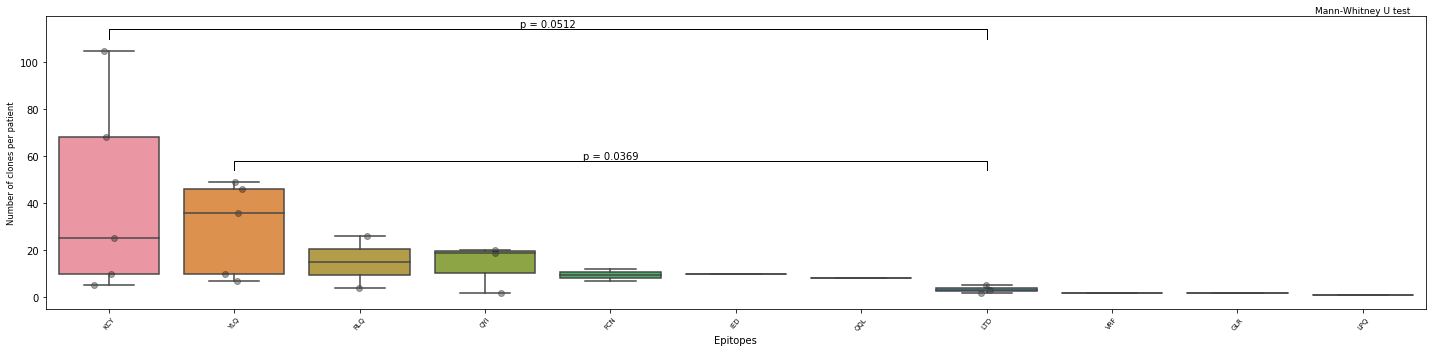

In [4]:
#clonotypes per epitope
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig4/'
path_to_4d = path_all+'4D/'
os.makedirs(path_to_4d, exist_ok = True)

path_to_4c = path_all+'4C/'
path_to_with_d14_all_epitope_specific_clones = path_to_4c+'all_epi_specific_w_d14_info.txt'
with_d14_all_epitope_specific_clones = pd.read_csv(path_to_with_d14_all_epitope_specific_clones, delimiter='\t')
summary_epitope = pd.DataFrame()

for patient in list(with_d14_all_epitope_specific_clones['patient'].unique()):
    pat_clones = with_d14_all_epitope_specific_clones[with_d14_all_epitope_specific_clones['patient']==patient]
    for epitope in list(pat_clones['type'].unique()):
        file = pat_clones[pat_clones['type']==epitope]
        new_row = {'patient':patient, 'epitope':epitope,
                  'Number of clones':len(file)}
        summary_epitope = summary_epitope.append(new_row, ignore_index=True)
summary_epitope_path = path_to_4d + 'number_of_clones_per_epitope_per_patient.txt'
#summary_epitope.to_csv(summary_epitope_path, sep='\t', index=False)
summary_epitope = summary_epitope.sort_values(by='Number of clones', ascending=False)
#boxplot
plt.figure()
plt.rcParams["figure.figsize"] = (20,5)

ax = sns.boxplot(x="epitope", y="Number of clones", data=summary_epitope)#, palette=pallet_wells, saturation=1)
plt.xticks(rotation=50,fontsize='x-small')
ax.set_ylabel('Number of clones per patient',fontsize='small')
ax.set_xlabel('Epitopes')
#ax.set_ylim([-0.05, 1.15])
ax.set_title('')

x = np.random.normal(0, 0.06, size=len(summary_epitope[summary_epitope['epitope']=='KCY']))
plt.scatter(x, summary_epitope[summary_epitope['epitope']=='KCY']['Number of clones'], c='#222222', alpha=0.4)
x = np.random.normal(1, 0.06, size=len(summary_epitope[summary_epitope['epitope']=='YLQ']))
plt.scatter(x, summary_epitope[summary_epitope['epitope']=='YLQ']['Number of clones'], c='#222222', alpha=0.4)
x = np.random.normal(2, 0.06, size=len(summary_epitope[summary_epitope['epitope']=='RLQ']))
plt.scatter(x, summary_epitope[summary_epitope['epitope']=='RLQ']['Number of clones'], c='#222222', alpha=0.4)
x = np.random.normal(3, 0.06, size=len(summary_epitope[summary_epitope['epitope']=='QYI']))
plt.scatter(x, summary_epitope[summary_epitope['epitope']=='QYI']['Number of clones'], c='#222222', alpha=0.4)

x = np.random.normal(7, 0.06, size=len(summary_epitope[summary_epitope['epitope']=='LTD']))
plt.scatter(x, summary_epitope[summary_epitope['epitope']=='LTD']['Number of clones'], c='#222222', alpha=0.4)


y, h, col = summary_epitope[summary_epitope['epitope']=='KCY']['Number of clones'].max() + 5, 4, 'k'
plt.plot([0, 0, 7, 7], [y, y+h, y+h, y], lw=1, c=col)
plt.text((0+7)*.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(summary_epitope[summary_epitope['epitope']=='KCY']['Number of clones']), 
                    list(summary_epitope[summary_epitope['epitope']=='LTD']['Number of clones']))[1],4)),
         ha='center', va='bottom', color=col, fontsize=10)

y, h, col = summary_epitope[summary_epitope['epitope']=='YLQ']['Number of clones'].max() + 5, 4, 'k'
plt.plot([1, 1, 7, 7], [y, y+h, y+h, y], lw=1, c=col)
plt.text((1+7)*.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(summary_epitope[summary_epitope['epitope']=='YLQ']['Number of clones']), 
                    list(summary_epitope[summary_epitope['epitope']=='LTD']['Number of clones']))[1],4)),
         ha='center', va='bottom', color=col, fontsize=10)


plt.text(10, 120, "Mann-Whitney U test",
         ha='center', va='bottom', color=col, fontsize=9)


plt.tight_layout()
path_to_png = path_to_4d+'epitopes_clonality.png'
#plt.savefig(path_to_png,bbox_inches='tight', dpi=250)
plt.show()

#Count statistics to table
statistics = pd.DataFrame()

for x in list(summary_epitope['epitope'].unique()):
    for y in list(summary_epitope['epitope'].unique()):
        if x!=y:
            if list(summary_epitope[summary_epitope['epitope']==x]['Number of clones']>1)!=list(summary_epitope[summary_epitope['epitope']==y]['Number of clones']>1):
                pval = mann_whitney_u_test(list(summary_epitope[summary_epitope['epitope']==x]['Number of clones']), 
                        list(summary_epitope[summary_epitope['epitope']==y]['Number of clones']))[1]
                new_row = {'X': x, 'Y': y, 'Pval': pval}
                statistics = statistics.append(new_row, ignore_index=True)
            
path_statistics = path_to_4d+'epitopes_pval.txt'
#statistics.to_csv(path_statistics, sep='\t', index=False)

statistics = pd.DataFrame()
pval = mann_whitney_u_test(list(summary_epitope[summary_epitope['epitope']=='YLQ']['Number of clones']), 
        list(summary_epitope[summary_epitope['epitope']=='KCY']['Number of clones']))[1]
new_row = {'X': 'YLQ', 'Y': 'KCY', 'Pval': pval}
statistics = statistics.append(new_row, ignore_index=True)
path_statistics_ylq_kcy = path_to_4d+'YLQ_KCY_pval.txt'
statistics.to_csv(path_statistics_ylq_kcy, sep='\t', index=False)

In [5]:
statistics

,X,Y,Pval
0,YLQ,KCY,0.916563


# 4E

In [48]:
all_epitope_specific_clones['patient'].unique()

array([1752, 1775, 1782, 1810, 1813, 1753, 1776, 1800, 1780, 1802, 1771,
       1787, 1792])

In [49]:
#overlap cd8/undef/epitope
patients = list(with_d14_all_epitope_specific_clones['patient'].unique())
#patients = ['1753', '1752']
path_all = '/Users/labuser/../../Volumes/LTI/TeamFolder/Data/Petrovax/data_analysis/check codes and results/Fig4/'
path_to_4e = path_all+'4E/'
os.makedirs(path_to_4e, exist_ok = True)
path_to_txt = path_to_4e+'tables/'
os.makedirs(path_to_txt, exist_ok = True)
print(len(with_d14_all_epitope_specific_clones))
all_epitope_specific_clones_cd8 = with_d14_all_epitope_specific_clones[(with_d14_all_epitope_specific_clones['type']!='IED')&(with_d14_all_epitope_specific_clones['type']!='QQL')]
print(len(all_epitope_specific_clones_cd8))
summary_venn = pd.DataFrame()
all_clones_w_cd8_w_undef=pd.DataFrame()
for patient in patients:
    patient_epitope_specific = all_epitope_specific_clones_cd8[all_epitope_specific_clones_cd8['patient']==int(patient)]
    
    path_to_s_specicif_cd8 = path_all+'clones_from_venn/'+str(patient)+'/cd8.txt'
    s_spec_cd8 = pd.read_csv(path_to_s_specicif_cd8, delimiter='\t').rename(columns={'cdr3':'factor', 'type':'CD8'})
    s_spec_cd8['CD8']='CD8'
    path_to_s_specicif_undef = path_all+'clones_from_venn/'+str(patient)+'/undef.txt'
    s_spec_undef = pd.read_csv(path_to_s_specicif_undef, delimiter='\t').rename(columns={'cdr3':'factor', 'type':'Undef'})
    s_spec_undef['Undef']='Undef'
    epi_in_cd8 = s_spec_cd8.merge(patient_epitope_specific, how='outer', on=['factor']).fillna(value={'type':'','CD8':'',
                                                                'count':0, 'freq':0, 'public':0, 'patient': str(patient)})
    epi_in_undef_and_cd8 = s_spec_undef.merge(epi_in_cd8, how='outer', on=['factor']).fillna(value={'type':'','CD8':'','Undef':'',
                                                                'count':0, 'freq':0, 'public':0, 'patient': str(patient)})
    
    all_clones_w_cd8_w_undef = all_clones_w_cd8_w_undef.append(epi_in_undef_and_cd8)
    path_to_cd8_and_undef_txt = path_to_txt + str(patient) + '__epi_w_cd8_and_undef.txt'
    epi_in_undef_and_cd8.to_csv(path_to_cd8_and_undef_txt, sep='\t', index=False)
    
    only_cd8 = len(epi_in_undef_and_cd8[(epi_in_undef_and_cd8['CD8']!='')&(epi_in_undef_and_cd8['type']=='')])
    only_undef = len(epi_in_undef_and_cd8[(epi_in_undef_and_cd8['Undef']!='')&(epi_in_undef_and_cd8['type']=='')])
    cd8_and_epi = len(epi_in_undef_and_cd8[(epi_in_undef_and_cd8['CD8']!='')&(epi_in_undef_and_cd8['type']!='')])
    undef_and_epi = len(epi_in_undef_and_cd8[(epi_in_undef_and_cd8['Undef']!='')&(epi_in_undef_and_cd8['type']!='')])
    only_epitope = len(epi_in_undef_and_cd8[(epi_in_undef_and_cd8['Undef']=='')&(epi_in_undef_and_cd8['CD8']=='')&(epi_in_undef_and_cd8['type']!='')])
    print(only_cd8+only_undef+cd8_and_epi+undef_and_epi+only_epitope, ' = ', len(epi_in_undef_and_cd8))
    summary_venn = summary_venn.append({'patient':str(patient), 'Only_CD8':only_cd8, 'Only_epitope':only_epitope,
                                       'Undef_only':only_undef, 'CD8_and_epitope':cd8_and_epi, 
                                       'Undef_and_epitope':undef_and_epi}, ignore_index=True)
summary_venn.loc['Total']= summary_venn.sum()
summary_venn.loc[['Total'], ['patient']]='Total'
summary_venn_path = path_to_4e + 'summary_venn_cd8_and_undef_intersection.txt'
summary_venn.to_csv(summary_venn_path, sep='\t', index=False)
summary_venn


484
466
98  =  98
45  =  45
79  =  79
179  =  179
93  =  93
203  =  203
54  =  54
74  =  74
45  =  45
115  =  115
34  =  34
105  =  105
89  =  89


,patient,Only_CD8,Only_epitope,Undef_only,CD8_and_epitope,Undef_and_epitope
0,1752,23.0,33.0,42.0,0.0,0.0
1,1775,10.0,14.0,19.0,2.0,0.0
2,1782,27.0,49.0,3.0,0.0,0.0
3,1810,14.0,135.0,24.0,4.0,2.0
4,1813,7.0,68.0,15.0,3.0,0.0
5,1753,143.0,20.0,38.0,2.0,0.0
6,1776,29.0,2.0,23.0,0.0,0.0
7,1800,22.0,11.0,40.0,1.0,0.0
8,1780,30.0,2.0,13.0,0.0,0.0
9,1802,60.0,19.0,35.0,1.0,0.0


# 4F 

In [50]:
no_w2 = ['1769']
no_restim =['1813']
no_s6m = ['1775', '1782']
no_6m = ['1775', '1790']
no_d28 = ['1802']

In [53]:
#Dynamics

patients = list(with_d14_all_epitope_specific_clones['patient'].unique())

#patients = ['1810']
summary_timeline_all = pd.DataFrame()
all_epitope_specific_clones_not_ornot_path = path_all+'good_all_epi_clones.txt'
all_epitope_specific_clones_not_ornot = pd.read_csv(all_epitope_specific_clones_not_ornot_path, delimiter='\t')

path_to_4f = path_all+'4F/'
os.makedirs(path_to_4f, exist_ok = True)

path_all_wells = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/wells/nc.vdj.p'

dynamics_full = pd.DataFrame()

for patient in patients:
    patient_epitope_specific = all_epitope_specific_clones_not_ornot[all_epitope_specific_clones_not_ornot['patient']==int(patient)]
    patient_path = path_to_4f + str(patient) + '/'
    os.makedirs(patient_path, exist_ok = True)
    
    d0_path = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/totals/nc.vdj.p'+str(patient)+'_total_PBMC_day_0_clonotypes.txt'
    d0 = pd.read_csv(d0_path, delimiter='\t')
    d0 = make_factor_nt_days(d0, 'd0')
    
    d14_path = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/totals/nc.vdj.p'+str(patient)+'_total_PBMC_day_14_clonotypes.txt'
    d14 = pd.read_csv(d14_path, delimiter='\t')
    d14 = make_factor_nt_days(d14, 'd14')
    
    if str(patient) in no_d28:
        d28 = empty_df
    else:
        d28_path = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/totals/nc.vdj.p'+str(patient)+'_total_PBMC_day_28_clonotypes.txt'
        d28 = pd.read_csv(d28_path, delimiter='\t')
    d28 = make_factor_nt_days(d28, 'd28')
    
    if str(patient) in no_6m:
        m6 = empty_df
    else:
        m6_path = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/totals/nc.vdj.p'+str(patient)+'_total_PBMC_6M_clonotypes.txt'
        m6 = pd.read_csv(m6_path, delimiter='\t')
    m6 = make_factor_nt_days(m6, 'm6')
        
    if str(patient) in no_s6m:
        s6m = empty_df
    else:  
        s6m_path = '/Users/labuser/../../Volumes/LTI/BigData/NGS/NGS_seq_data/Petrovax/6M_spike/nc.vdj.p'+str(patient)+'_Spike_exp_6M_clonotypes.txt'
        s6m = pd.read_csv(s6m_path, delimiter='\t')
    s6m = make_factor_nt_days(s6m, 's6m')

    path_exp_d14_w1 = path_all_wells + str(patient) + '_Spike_exp_puls_well_1_clonotypes.txt'
    d14_w1 = pd.read_csv(path_exp_d14_w1, delimiter='\t')
    d14_w1 = make_factor_nt_days(d14_w1, 'w1')
    path_exp_d14_w2 = path_all_wells + str(patient) + '_Spike_exp_puls_well_2_clonotypes.txt'
    try:
        d14_w2 = pd.read_csv(path_exp_d14_w2, delimiter='\t')
        d14_w2 = make_factor_nt_days(d14_w2, 'w2')
        d14_exp = d14_w1.merge(d14_w2, how='outer', on='cdr3').fillna(0)
        d14_exp['freq_well'] = (d14_exp['freq_w1'] + d14_exp['freq_w2'])/2.0
        d14_exp = d14_exp.loc[:, ['cdr3', 'freq_well']]
        print(d14_exp['freq_well'].sum())
    except:
        d14_exp = d14_w1.copy()
        d14_exp = d14_exp.rename(columns={'freq_w1': 'freq_well'})
    d14_exp['type_well'] = 'well'
    #Epitope
    dynamics = patient_epitope_specific.merge(d0, how='left', on='factor').merge(d14, how='left', 
                                              on='factor').merge(d28, how='left', on='factor').merge(m6, how='left',
                                              on='factor').merge(s6m, how='left', on='factor').merge(d14_exp, how='left',
                                              on='factor').reset_index(drop=True).fillna(0)
    dynamics_full = dynamics_full.append(dynamics)
    
    dict_dynamics = {
        'patient': str(patient), 'num_epi_specific': len(dynamics),
        'num_d0_epi_specific': len(dynamics[dynamics['freq_d0']!=0]), 
        'num_d14_epi_specific': len(dynamics[dynamics['freq_d14']!=0]),
        'num_d28_epi_specific': len(dynamics[dynamics['freq_d28']!=0]), 
        'num_6m_epi_specific': len(dynamics[dynamics['freq_m6']!=0]), 
        'num_s6m_epi_specific': len(dynamics[dynamics['freq_s6m']!=0]),
        'num_s14d_epi_specific': len(dynamics[dynamics['freq_well']!=0]),
        
        'freq_d0_epi_specific': dynamics[dynamics['freq_d0']!=0]['freq_d0'].sum(), 
        'freq_d14_epi_specific': dynamics[dynamics['freq_d14']!=0]['freq_d14'].sum(),
        'freq_d28_epi_specific': dynamics[dynamics['freq_d28']!=0]['freq_d28'].sum(), 
        'freq_6m_epi_specific': dynamics[dynamics['freq_m6']!=0]['freq_m6'].sum(), 
        'freq_s6m_epi_specific': dynamics[dynamics['freq_s6m']!=0]['freq_s6m'].sum(),
        'freq_s14d_epi_specific': dynamics[dynamics['freq_well']!=0]['freq_well'].sum()
        
    }
    
    summary_timeline_all = summary_timeline_all.append(dict_dynamics, ignore_index = True)
    
summary_timeline_all = summary_timeline_all.loc[:, ['patient', 'num_epi_specific', 
        'num_d0_epi_specific', 'num_d14_epi_specific',
        'num_d28_epi_specific', 'num_6m_epi_specific',
        'num_s6m_epi_specific', 'num_s14d_epi_specific',
        
       'freq_d0_epi_specific', 'freq_d14_epi_specific',
        'freq_d28_epi_specific', 'freq_6m_epi_specific', 
        'freq_s6m_epi_specific', 'freq_s14d_epi_specific']]
    
summary_timeline_path = path_to_4f+'summary_dynamics_num_epi_specific_nt.txt'
summary_timeline_all.to_csv(summary_timeline_path, sep='\t', index=False)

summary_timeline_all


,patient,num_epi_specific,num_d0_epi_specific,num_d14_epi_specific,num_d28_epi_specific,num_6m_epi_specific,num_s6m_epi_specific,num_s14d_epi_specific,freq_d0_epi_specific,freq_d14_epi_specific,freq_d28_epi_specific,freq_6m_epi_specific,freq_s6m_epi_specific,freq_s14d_epi_specific
0,1752,33.0,3.0,25.0,11.0,3.0,11.0,19.0,0.004665,0.004070,0.002377,0.002647,0.058917,0.009342
1,1775,16.0,4.0,10.0,7.0,0.0,0.0,8.0,0.006475,0.004859,0.010213,0.000000,0.000000,0.026573
2,1782,49.0,9.0,20.0,15.0,8.0,0.0,11.0,0.008110,0.007816,0.008052,0.006798,0.000000,0.024169
3,1810,141.0,3.0,86.0,40.0,1.0,14.0,61.0,0.000346,0.005823,0.001603,0.000392,0.008912,0.027815
4,1813,71.0,0.0,45.0,4.0,0.0,14.0,17.0,0.000000,0.002435,0.000144,0.000000,0.000108,0.002579
5,1753,32.0,0.0,14.0,2.0,0.0,9.0,11.0,0.000000,0.000364,0.000020,0.000000,0.000112,0.004555
6,1776,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000017,0.000000,0.000000,0.000000,0.000000
7,1800,12.0,3.0,8.0,6.0,2.0,4.0,5.0,0.001535,0.002179,0.001627,0.000656,0.041045,0.080066
8,1780,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.000000,0.000154,0.000000,0.000000,0.000000,0.000015
9,1802,20.0,0.0,13.0,0.0,0.0,7.0,10.0,0.000000,0.001032,0.000000,0.000000,0.000238,0.000404


In [57]:
#By epi
patients_list = list(dynamics_full['patient'].unique())
#patients_list = [1752]
epi_dynamics_summary = pd.DataFrame()
for patient in patients_list:
    patient_dynamics = dynamics_full[dynamics_full['patient']==patient]
    epitope_list = list(patient_dynamics['type'].unique())
    for epi in epitope_list:
        epi_dynamics = patient_dynamics[patient_dynamics['type']==epi]
        dict_dynamics = {
        'patient': str(patient), 'epitope': epi, 'num_epi_specific': len(epi_dynamics),
        'num_d0_epi_specific': len(epi_dynamics[epi_dynamics['freq_d0']!=0]), 
        'num_d14_epi_specific': len(epi_dynamics[epi_dynamics['freq_d14']!=0]),
        'num_d28_epi_specific': len(epi_dynamics[epi_dynamics['freq_d28']!=0]), 
        'num_6m_epi_specific': len(epi_dynamics[epi_dynamics['freq_m6']!=0]), 
        'num_s6m_epi_specific': len(epi_dynamics[epi_dynamics['freq_s6m']!=0]),
        'num_s14d_epi_specific': len(epi_dynamics[epi_dynamics['freq_well']!=0]),
        
        'freq_d0_epi_specific': epi_dynamics[epi_dynamics['freq_d0']!=0]['freq_d0'].sum(), 
        'freq_d14_epi_specific': epi_dynamics[epi_dynamics['freq_d14']!=0]['freq_d14'].sum(),
        'freq_d28_epi_specific': epi_dynamics[epi_dynamics['freq_d28']!=0]['freq_d28'].sum(), 
        'freq_6m_epi_specific': epi_dynamics[epi_dynamics['freq_m6']!=0]['freq_m6'].sum(), 
        'freq_s6m_epi_specific': epi_dynamics[epi_dynamics['freq_s6m']!=0]['freq_s6m'].sum(),
        'freq_s14d_epi_specific': epi_dynamics[epi_dynamics['freq_well']!=0]['freq_well'].sum()
        }
        epi_dynamics_summary = epi_dynamics_summary.append(dict_dynamics, ignore_index=True)
epi_dynamics_summary_path = path_to_4f + 'by_epi_dynamics_summary.txt'
epi_dynamics_summary.to_csv(epi_dynamics_summary_path, sep='\t', index=False)



/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


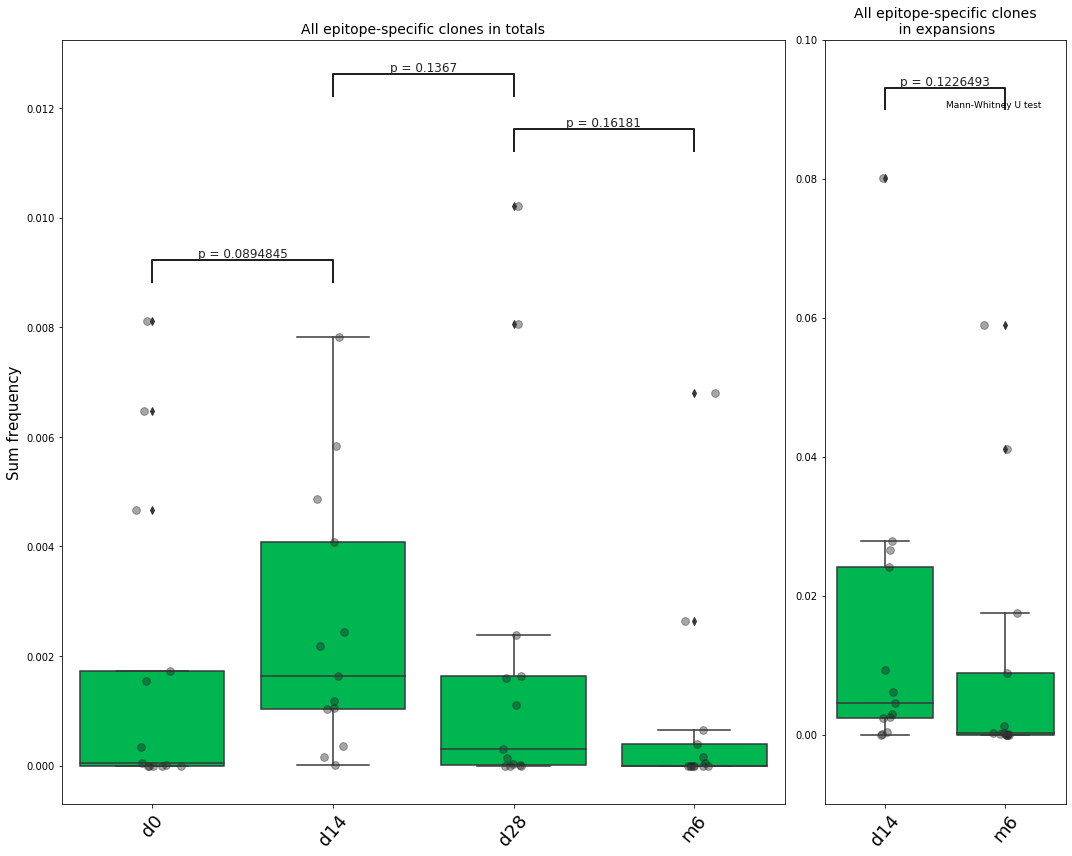

<Figure size 1080x864 with 0 Axes>

In [60]:
#plot all (not separated by epitopes) #Sum freq
from pandas.api.types import CategoricalDtype

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

summary_timeline_all1 = summary_timeline_all.melt(id_vars=['patient'], 
              value_vars=['freq_d0_epi_specific', 'freq_d14_epi_specific', 'freq_d28_epi_specific',
                          'freq_6m_epi_specific', 'freq_s6m_epi_specific', 'freq_s14d_epi_specific'],
              var_name='day', value_name='sum_freq')
summary_timeline_all2 = summary_timeline_all.melt(id_vars=['patient'], 
              value_vars=['num_d0_epi_specific', 'num_d14_epi_specific', 'num_d28_epi_specific', 'num_6m_epi_specific',
                         'num_s6m_epi_specific', 'num_s14d_epi_specific'], 
              var_name='day', value_name='num')
summary_timeline_all1 = summary_timeline_all1.replace({'freq_d0_epi_specific':'d0',
               'freq_d14_epi_specific':'d14', 'freq_d28_epi_specific':'d28','freq_6m_epi_specific':'m6',
               'freq_s6m_epi_specific':'s6m', 'freq_s14d_epi_specific':'s14d'})
summary_timeline_all2 = summary_timeline_all2.replace({'num_d0_epi_specific':'d0',
               'num_d14_epi_specific':'d14', 'num_d28_epi_specific':'d28','num_6m_epi_specific':'m6',
               'num_s6m_epi_specific':'s6m', 'num_s14d_epi_specific':'s14d'})
summary_timeline_all_melt = summary_timeline_all1.merge(summary_timeline_all2, on=['patient', 'day'])


all_patients_df_dropped_to_plot = summary_timeline_all_melt[(summary_timeline_all_melt['day']!='s6m')&(summary_timeline_all_melt['day']!='s14d')]
box_order = CategoricalDtype(
    ['d0', 'd14', 'd28', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values('day')
pallet_wells = ['#00B651']
plt.figure()
plt.rcParams["figure.figsize"] = (15,12)

ax = sns.boxplot(x="day", y="sum_freq", data=all_patients_df_dropped_to_plot, palette=pallet_wells, saturation=1, ax=a0)
plt.sca(a0)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('Sum frequency',fontsize='15')
ax.set_xlabel('')
ax.set_title('All epitope-specific clones in totals',fontsize=14)# (0.0000005=0)',fontsize='small')# )

x = np.random.normal(0, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d0']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d0']['sum_freq'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(1, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['sum_freq'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(2, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']['sum_freq'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(3, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['sum_freq'], c='#222222', alpha=0.4, s=60)


y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['sum_freq'].max() + 0.001, 0.0004, 'k'
a0.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=2, c='#222222')
a0.text(0.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d0']['sum_freq']))[1],7)),
                     ha='center', va='bottom', color='#222222', fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')]['sum_freq'].max() + 0.001, 0.0004, 'k'
a0.plot([2, 2, 3, 3], [y, y+h, y+h, y], lw=2, c='#222222')
a0.text(2.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['sum_freq']))[1],5)),
                     ha='center', va='bottom', color='#222222', fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')]['sum_freq'].max() + 0.002, 0.0004, 'k'
a0.plot([2, 2, 1, 1], [y, y+h, y+h, y], lw=2, c='#222222')
a0.text(1.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['sum_freq']))[1],5)),
                     ha='center', va='bottom', color='#222222', fontsize=12)

all_patients_df_dropped_to_plot = summary_timeline_all_melt[(summary_timeline_all_melt['day']=='s6m')|(summary_timeline_all_melt['day']=='s14d')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'s6m':'m6', 's14d':'d14'})
box_order = CategoricalDtype(
    ['d14', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values('day')
pallet_wells = ['#00B651']

ax = sns.boxplot(x="day", y="sum_freq", data=all_patients_df_dropped_to_plot, palette=pallet_wells, saturation=1,ax=a1)
plt.sca(a1)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim([-0.01, 0.1])
ax.set_title('All epitope-specific clones\n in expansions',fontsize=14)# (0.0000005=0)',fontsize='small')# )

x = np.random.normal(0, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']))
a1.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['sum_freq'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(1, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']))
a1.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['sum_freq'], c='#222222', alpha=0.4, s=60)


y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['sum_freq'].max() + 0.01, 0.003, 'k'
a1.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=2, c='#222222')
a1.text(0.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['sum_freq']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['sum_freq']))[1],7)),
         ha='center', va='bottom', color='#222222', fontsize=12)


a1.text(0.9, 0.09, "Mann-Whitney U test",
         ha='center', va='bottom', color='black', fontsize=9)

path_to_png = path_to_4f+'4F(sum_freq).png'
plt.tight_layout()
plt.savefig(path_to_png,bbox_inches='tight', dpi=350)
plt.show()


#Count statistics to table
statistics = pd.DataFrame()

for x in list(summary_timeline_all_melt['day'].unique()):
    for y in list(summary_timeline_all_melt['day'].unique()):
        if x!=y:
            pval = mann_whitney_u_test(list(summary_timeline_all_melt[summary_timeline_all_melt['day']==x]['sum_freq']), 
                    list(summary_timeline_all_melt[summary_timeline_all_melt['day']==y]['sum_freq']))[1]
            new_row = {'X': x, 'Y': y, 'Pval': pval}
            statistics = statistics.append(new_row, ignore_index=True)
            
path_statistics = path_to_4f+'pval(all_clones_sum_freq).txt'
statistics.to_csv(path_statistics, sep='\t', index=False)



/Users/labuser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


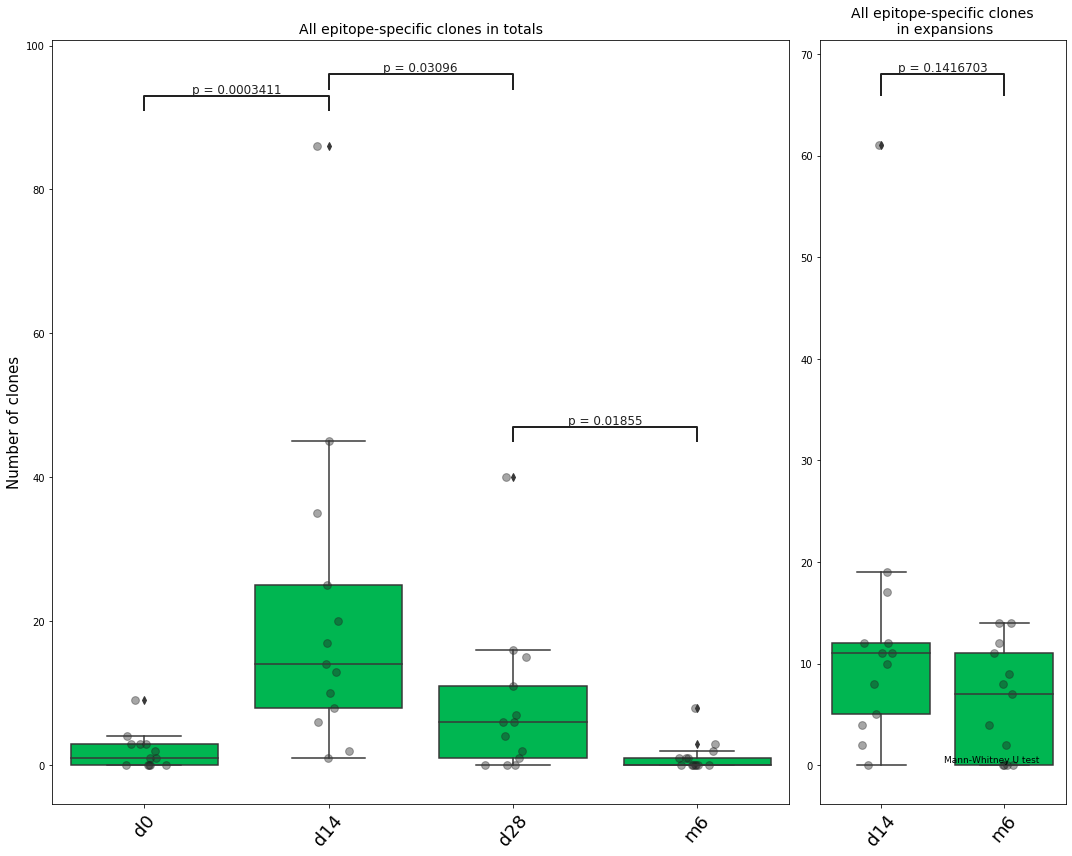

<Figure size 1080x864 with 0 Axes>

In [59]:
#Plot num clones
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

all_patients_df_dropped_to_plot = summary_timeline_all_melt[(summary_timeline_all_melt['day']!='s6m')&(summary_timeline_all_melt['day']!='s14d')]
box_order = CategoricalDtype(
    ['d0', 'd14', 'd28', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values('day')
pallet_wells = ['#00B651']
plt.figure()
plt.rcParams["figure.figsize"] = (15,12)

ax = sns.boxplot(x="day", y="num", data=all_patients_df_dropped_to_plot, palette=pallet_wells, saturation=1, ax=a0)
plt.sca(a0)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('Number of clones',fontsize='15')
ax.set_xlabel('')
ax.set_title('All epitope-specific clones in totals',fontsize=14)# (0.0000005=0)',fontsize='small')# )

x = np.random.normal(0, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d0']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d0']['num'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(1, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['num'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(2, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']['num'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(3, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']))
a0.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['num'], c='#222222', alpha=0.4, s=60)


y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['num'].max() + 5, 2, 'k'
a0.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=2, c='#222222')
a0.text(0.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['num']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d0']['num']))[1],7)),
                     ha='center', va='bottom', color='#222222', fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d28')]['num'].max() + 5, 2, 'k'
a0.plot([2, 2, 3, 3], [y, y+h, y+h, y], lw=2, c='#222222')
a0.text(2.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']['num']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['num']))[1],5)),
                     ha='center', va='bottom', color='#222222', fontsize=12)

y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['num'].max() + 8, 2, 'k'
a0.plot([2, 2, 1, 1], [y, y+h, y+h, y], lw=2, c='#222222')
a0.text(1.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d28']['num']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['num']))[1],5)),
                     ha='center', va='bottom', color='#222222', fontsize=12)

all_patients_df_dropped_to_plot = summary_timeline_all_melt[(summary_timeline_all_melt['day']=='s6m')|(summary_timeline_all_melt['day']=='s14d')]
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.replace({'s6m':'m6', 's14d':'d14'})
box_order = CategoricalDtype(
    ['d14', 'm6'], 
    ordered=True
)
all_patients_df_dropped_to_plot['day'] = all_patients_df_dropped_to_plot['day'].astype(box_order)
all_patients_df_dropped_to_plot = all_patients_df_dropped_to_plot.sort_values('day')
pallet_wells = ['#00B651']

ax = sns.boxplot(x="day", y="num", data=all_patients_df_dropped_to_plot, palette=pallet_wells, saturation=1,ax=a1)
plt.sca(a1)
plt.xticks(rotation=50,fontsize=18)
ax.set_ylabel('')
ax.set_xlabel('')
#ax.set_ylim([-0.01, 0.1])
ax.set_title('All epitope-specific clones\n in expansions',fontsize=14)# (0.0000005=0)',fontsize='small')# )

x = np.random.normal(0, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']))
a1.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['num'], c='#222222', alpha=0.4, s=60)

x = np.random.normal(1, 0.06, size=len(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']))
a1.scatter(x, all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['num'], c='#222222', alpha=0.4, s=60)


y, h, col = all_patients_df_dropped_to_plot[(all_patients_df_dropped_to_plot['day']=='d14')]['num'].max() + 5, 2, 'k'
a1.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=2, c='#222222')
a1.text(0.5, y+h, 'p = '+str(round(mann_whitney_u_test(list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='d14']['num']), 
                    list(all_patients_df_dropped_to_plot[all_patients_df_dropped_to_plot['day']=='m6']['num']))[1],7)),
         ha='center', va='bottom', color='#222222', fontsize=12)


a1.text(0.9, 0.09, "Mann-Whitney U test",
         ha='center', va='bottom', color='black', fontsize=9)

path_to_png = path_to_4f+'4F(num).png'
plt.tight_layout()
plt.savefig(path_to_png,bbox_inches='tight', dpi=350)
plt.show()


#Count statistics to table
statistics = pd.DataFrame()

for x in list(summary_timeline_all_melt['day'].unique()):
    for y in list(summary_timeline_all_melt['day'].unique()):
        if x!=y:
            pval = mann_whitney_u_test(list(summary_timeline_all_melt[summary_timeline_all_melt['day']==x]['num']), 
                    list(summary_timeline_all_melt[summary_timeline_all_melt['day']==y]['num']))[1]
            new_row = {'X': x, 'Y': y, 'Pval': pval}
            statistics = statistics.append(new_row, ignore_index=True)
            
path_statistics = path_to_4f+'pval(all_clones_num).txt'
statistics.to_csv(path_statistics, sep='\t', index=False)